In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
from tensorflow import  keras
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler,StandardScaler,scale
from skimage.measure import block_reduce
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout

In [2]:
def load_data():
    als = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/ALS.mat',)["data"].transpose()  #(262134, 321)
    normal = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/normal.mat')['data'].transpose() # (262134, 270) 
    myopathy = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/myopathie.mat')['data'].transpose() #(262134, 315)
    return als,normal,myopathy

In [3]:

def scale_data_minmax(data):
#type of scaler that scales the minimum and maximum values to be 0 and 1 respectively. 
    scaler = MinMaxScaler()
#fit_transform() then it will calculate the mean(μ) and standard deviation(σ) of the feature F at a time it will transform the data points of the feature F.    
    normalized_data =scaler.fit_transform(data)


    return normalized_data

In [71]:
def scale_data_standard(data):
    data_array = np.array(data)
    data_reshaped = data_array.reshape(-1, data_array.shape[-1])
    #divide by variance and subtract mean for data 
    scaled_data = scale(data_reshaped, axis=0)
    return scaled_data


In [5]:
def gen_tensors_list(data,dim):
    dataset  = list()
    for i in range (len(data)):
        arg = tf.convert_to_tensor(data[i], dtype=tf.float32)
        arg = tf.reshape(arg,dim)
        dataset.append(arg)

    return dataset

In [74]:
#def windowing_fun(data,window_size=1000,overlap=100):
#    windowed_data = [data[j][i : i + window_size] for j in range(0,len(data)) for i in range(0, len(data[j]), window_size-overlap)]
#    final_data = [windowed_data[i] for i in range(len(windowed_data)) if len(windowed_data[i]) == window_size ]
#    return final_data
def windowing_fun(data, window_size=1000, overlap=100):
    # Add a new axis to the data
    data = np.array(data)[:, :, np.newaxis]
    windowed_data = [d[:,2:] for d in data] # exclude first two columns
    windowed_data = [w[i : i + window_size] for w in windowed_data for i in range(0, len(w), window_size-overlap)]
    final_data = [w for w in windowed_data if w.shape[0] == window_size ]
    return final_data


In [285]:
def windowing_fun_(data,window_size=1000,overlap=100):
    print(data.shape)
    data = np.squeeze(data, axis=1)
    print(data.shape)
    windowed_data = [data[j][i : i + window_size] for j in range(0,len(data)) for i in range(0, len(data[j]), window_size-overlap)]
    print("WD",windowed_data.shape)
    final_data = [windowed_data[i] for i in range(len(windowed_data)) if len(windowed_data[i]) == window_size ]
    #print(final_data)
    return final_data

In [7]:
def load_file_names():
    als = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/ALS.mat',)["files"]  #(262134, 321)
    normal = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/normal.mat')['files'] # (262134, 270) 
    myopathy = scipy.io.loadmat('C:/Users/lenovo/OneDrive/Documents/drive-download-20230214T190624Z-001/myopathie.mat')['files'] #(262134, 315)
    return als,normal,myopathy

In [8]:
def generate_dataframe(data,files):
    df = pd.DataFrame([], columns=['type_signal',"num_personne","muscle","num_enregistrement","signal"])
    windowed_data = [{"signal": data[j],"type_signal":files[0][j][0][5],"num_personne": files[0][j][0][6:8],"muscle": files[0][j][0][8:10],"num_enregistrement":files[0][j][0][10:12] } for j in range(0,len(data)) ]
    final_data = pd.DataFrame(windowed_data)
    #df =df.append(final_data, ignore_index=True)
    #df =pd.concat([df, final_data])
    df = pd.concat([df, final_data], ignore_index=True)
    return df

In [196]:
als, normal, myopathie = load_data()

In [197]:
alsfiles,normalfiles,myopathiefiles = load_file_names()

In [198]:
df = generate_dataframe(np.vstack((normal,als,myopathie)),np.concatenate((normalfiles,alsfiles,myopathiefiles),axis=1))

In [199]:
def f(row):
    return {"C":0,"A":1,"M":2}[row["type_signal"]]

df["num_class"] =df.apply(f, axis=1) 

In [200]:
df

,type_signal,num_personne,muscle,num_enregistrement,signal,num_class
0,C,01,BB,51,"[0.07629510948348212, 1.0681315327687495, -5.6...",0
1,C,01,BB,52,"[292.2102693217365, 288.2429236285954, 287.785...",0
2,C,01,BB,53,"[-31.204699778744185, -29.373617151140614, -28...",0
3,C,01,BB,54,"[-1.2207217517357138, 2.2888532845044636, -3.2...",0
4,C,01,BB,55,"[13.275349050125888, 10.376134889753567, 10.98...",0
...,...,...,...,...,...,...
901,M,07,VM,15,"[0.22888532845044635, 0.15259021896696423, 2.3...",2
902,M,07,VM,16,"[-0.07629510948348212, 3.1280994888227664, 4.9...",2
903,M,07,VM,17,"[-30.518043793392845, -32.73060196841383, -28....",2
904,M,07,VM,18,"[-63.17235065232319, -66.75822079804685, -70.7...",2


In [201]:
df = df.query("muscle=='BB'")

In [202]:
df

,type_signal,num_personne,muscle,num_enregistrement,signal,num_class
0,C,01,BB,51,"[0.07629510948348212, 1.0681315327687495, -5.6...",0
1,C,01,BB,52,"[292.2102693217365, 288.2429236285954, 287.785...",0
2,C,01,BB,53,"[-31.204699778744185, -29.373617151140614, -28...",0
3,C,01,BB,54,"[-1.2207217517357138, 2.2888532845044636, -3.2...",0
4,C,01,BB,55,"[13.275349050125888, 10.376134889753567, 10.98...",0
...,...,...,...,...,...,...
863,M,07,BB,18,"[1.9073777370870528, 2.059967956054017, 3.8910...",2
864,M,07,BB,19,"[-8.010986495765621, -4.425116350041963, -7.01...",2
865,M,07,BB,20,"[13.885709925993744, 10.986495765621424, 9.231...",2
866,M,07,BB,21,"[7.324330510414283, 7.782101167315176, 8.16357...",2


In [203]:
# Filter out rows where num_personne equals to '01'
test_df = df[df['num_personne'] == '01']
train_df = df[df['num_personne'] != '01']

# Split the remaining data into training and test sets
X_train = train_df[['type_signal', 'muscle', 'num_enregistrement', 'signal']]
y_train = train_df['num_class']
X_test = test_df[['type_signal', 'muscle', 'num_enregistrement', 'signal']]
y_test = test_df['num_class']


In [204]:
print(train_df)

    type_signal num_personne muscle num_enregistrement  \
30            C           02     BB                 51   
31            C           02     BB                 52   
32            C           02     BB                 53   
33            C           02     BB                 54   
34            C           02     BB                 55   
..          ...          ...    ...                ...   
863           M           07     BB                 18   
864           M           07     BB                 19   
865           M           07     BB                 20   
866           M           07     BB                 21   
867           M           07     BB                 22   

                                                signal  num_class  
30   [9.3842984664683, 13.73311970702678, 14.877546...          0  
31   [10.681315327687496, 8.545052262149996, 9.3080...          0  
32   [18.921187151903563, 19.684138246738385, 22.12...          0  
33   [0.8392462043183032, 1.449

In [205]:
X_train = train_df['signal'].tolist()
y_train = train_df['num_class'].tolist()

X_test = test_df['signal'].tolist()
y_test = test_df['num_class'].tolist()


In [206]:
# Separate train data into two dataframes by class
train_df_class0 = train_df[train_df['num_class'] == 0]
train_df_class1 = train_df[train_df['num_class'] == 1]
train_df_class2 = train_df[train_df['num_class'] == 2]

# Determine smaller size
min_size = min(len(train_df_class0), len(train_df_class1), len(train_df_class2))

# Randomly sample larger dataframe to match smaller one
train_df_class0 = train_df_class0.sample(n=min_size, random_state=42)
train_df_class1 = train_df_class1.sample(n=min_size, random_state=42)
train_df_class2 = train_df_class2.sample(n=min_size, random_state=42)

# Concatenate dataframes back together
train_df_balanced = pd.concat([train_df_class0, train_df_class1, train_df_class2])

# Split the balanced data into training and test sets
X_train = train_df_balanced[['signal']]
y_train = train_df_balanced['num_class']
X_test = test_df[['signal']]
y_test = test_df['num_class']


In [207]:
del df

In [208]:
print(X_train.shape)
#data augmentation using noise (on training data only)
num_samples, num_features = X_train.shape
noise = np.random.normal(loc=0, scale=0.1, size=(num_samples, num_features))
X_train_noisy = X_train + noise
print(X_train_noisy.shape)

(258, 1)
(258, 1)


In [209]:
X_train_augmented = np.vstack((X_train, X_train_noisy))

In [210]:
del  als,normal,myopathie, alsfiles,normalfiles, myopathiefiles

In [211]:
print(X_train_augmented.shape)

(516, 1)


In [212]:
type(X_train_augmented)

numpy.ndarray

In [213]:
X_train_augmented = X_train_augmented.tolist()

In [214]:
type(X_train_augmented)

list

In [215]:
#scaling the train set 
X_train_scaled = scale_data_standard(X_train_augmented)

In [216]:
#windowing the train set 
X_train_windowed = windowing_fun(X_train_scaled, window_size=1000, overlap=100)

In [217]:
type(X_test)

pandas.core.frame.DataFrame

In [218]:
X_test = X_test.values.tolist()

In [219]:
type(X_test)

list

In [220]:
#scaling the test set 
X_test_scaled = scale_data_standard(X_test)

In [221]:
#windowing the test set
X_test_windowed = windowing_fun(X_test_scaled, window_size=1000, overlap=100)

In [222]:
type(y_train)

pandas.core.series.Series

In [255]:
X = X_train[['signal']].values.tolist()
Y = y_train.values.tolist()

In [256]:
np.shape(X)

(258, 1, 262134)

In [257]:
print(Y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [258]:
count_normal = Y.count(0)
print(Y.count(0))
last_index_normal = count_normal - 1
last_index_normal

86


85

In [259]:
count_als = Y.count(1)
print(Y.count(1))
last_index_als = last_index_normal + count_als -1 
last_index_als

86


170

In [260]:
count_myopathy = Y.count(2)
print(Y.count(2))
last_index_myopathy = last_index_als + count_myopathy 
last_index_myopathy

86


256

In [274]:
print(X)

[[array([16.70862898, 11.59685664, 12.28351263, ...,  9.53688869,
        9.53688869,  9.84206912])], [array([ 8.69764248,  9.91836423,  7.93469139, ..., 25.78774701,
       26.77958343, 26.39810788])], [array([-7.62951095, -3.28068971, -1.98367285, ..., -9.61318379,
       -9.91836423, -9.38429847])], [array([-41.96231022, -43.4119173 , -46.31113146, ...,  97.73403525,
        97.3525597 ,  96.89478904])], [array([-7.32433051, -6.56137942, -2.74662394, ..., -6.33249409,
       -5.26436255, -9.61318379])], [array([-14.80125124, -12.81757839, -10.75761044, ...,  18.5397116 ,
        16.0982681 ,  16.32715343])], [array([-43.10673686, -43.18303197, -42.26749065, ..., -34.5616846 ,
       -33.34096284, -33.26466773])], [array([17.24269474, 18.5397116 , 19.60784314, ..., 11.13908598,
        4.88288701,  6.63767453])], [array([22.81223774, 21.43892576, 21.28633555, ..., 73.39589532,
       73.62478065, 74.69291218])], [array([ -4.57770657, -10.91020066, -13.04646372, ..., -42.72526131,
   

In [286]:
lst = X #just storying the value of X so that i don't have to run the upper cells

In [264]:
#check if arrays inside X have same length
same_length = all(len(x) == len(lst[0]) for x in lst)
print(same_length)

True


In [265]:
X = np.array(X)
type(X)

numpy.ndarray

In [270]:
#HERE IS THE PROBLEM WE ARE FACING FOR NOW
#our windowed signals are becoming empty
windowed_normal = len(windowing_fun_(X[:last_index_normal+1],400))
windowed_als = len(windowing_fun_(X[last_index_normal+1:last_index_als+1],400))
windowed_myopathie = len(windowing_fun_(X[last_index_als+1:],400))
windowed_normal, windowed_als, windowed_myopathie

(0, 0, 0)

In [287]:
X = lst #retreiving X

In [181]:
Y = [0]*(windowed_normal)+[1]*(windowed_als)+[2]*(windowed_myopathie)
print(np.asarray(Y).shape)


(0,)


In [90]:
Y  = Y*4
print(np.asarray(Y).shape)


(31720,)


In [91]:
X = windowing_fun(data,10000)
print(np.asarray(X).shape)


(31720, 10000)


In [92]:
del data

In [93]:
X = scale_data_standard(X)


In [94]:
print(X.shape)

(31720, 10000)


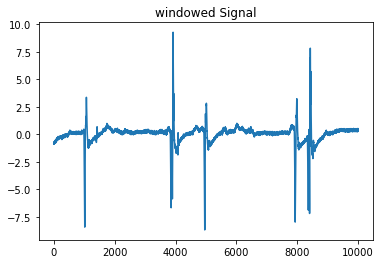

In [95]:
fig, axs = plt.subplots(1)
axs.plot(X[5000])
axs.set_title('windowed Signal')
plt.show()

In [96]:
tensors_list = gen_tensors_list(X,(1,10000))

In [97]:
print(np.asarray(tensors_list).shape)
print(np.asarray(Y).shape)

(31720, 1, 10000)
(31720,)


In [126]:
#X_train, X_test, y_train, y_test = train_test_split( tensors_list, Y, test_size=0.04,random_state=20)
X_train, X_val, y_train, y_val = train_test_split(tensors_list, Y, test_size=0.2, random_state=42)
np.shape(X_train), np.shape(y_train)


((25376, 1, 10000), (25376,))

In [132]:
X_train = np.array(X_train)
X_train_df = pd.DataFrame(X_train.reshape((X_train.shape[0], X_train.shape[2])))
y_train_df = pd.DataFrame(y_train)
print(X_train_df)

           0         1         2         3         4         5         6     \
0      0.361527  0.367414  0.338250  0.324976  0.340908  0.361844  0.366026   
1     -0.412581 -0.381435 -0.475449 -0.389634 -0.421369 -0.442443 -0.388249   
2      0.067321  0.070395  0.082381  0.059640  0.095861  0.071571  0.078321   
3     -0.708492 -0.643555 -0.646419 -0.739123 -0.711344 -0.670161 -0.759237   
4     -1.102998 -1.101553 -1.095843 -1.112303 -1.131098 -1.102339 -1.109689   
...         ...       ...       ...       ...       ...       ...       ...   
25371 -0.214169 -0.229699 -0.224092 -0.278425 -0.297389 -0.262986 -0.251102   
25372 -0.150714 -0.173680 -0.120094 -0.291059 -0.285956 -0.143059 -0.393128   
25373 -0.076328  0.020900  0.116184  0.129795  0.127851  0.195911  0.094793   
25374 -0.141343 -0.215724 -0.122937 -0.106297 -0.018278 -0.013635 -0.049941   
25375 -0.046217  0.061450  0.085798  0.134656  0.090445  0.171422  0.135365   

           7         8         9     ...      9990 

In [128]:
# Convert first element of each array in X_train and y_train to list
train_ids = [str(x[0]) for x in X_train]
y_train_ids = [str(y[0]) for y in y_train]

# Get index of rows with patient ID 'N2001A01BB'
train_A01_idx = train_ids.index('N2001A01BB')

# Select rows with patient A01 from the training set:
train_A01_X = X_train[train_A01_idx]
train_A01_y = y_train[train_A01_idx]

# Delete rows with patient A01 from the training set:
X_train = np.delete(X_train, train_A01_idx, axis=0)
y_train = np.delete(y_train, train_A01_idx, axis=0)

# Add rows with patient A01 to the test set:
X_test = np.vstack((X_test, train_A01_X))
y_test = np.concatenate((y_test, train_A01_y))


TypeError: 'int' object is not subscriptable

In [ ]:
patient_id = 1  # ID of the patient to be removed
mask = (X_train[:, 0] == patient_id)  # Mask for identifying signals of patient_id
indices = np.where(mask)[0]  # Indices of signals of patient_id

X_train_new = np.delete(X_train, indices, axis=0)


In [ ]:
patient_id = 1  # ID of the patient to be removed
mask = (X_train[:, 0] == patient_id)  # Mask for identifying signals of patient_id
indices = np.where(mask)[0]  # Indices of signals of patient_id

X_test_new = np.concatenate([X_test, X_train[indices]], axis=0)
y_test_new = np.concatenate([y_test, y_train[indices]], axis=0)


In [46]:
model = Sequential([
    #Conv2D(#of filters, filters size, activation function)
    #in keras for the first layer we always need to mention the input shape
    Conv1D(64, 3, activation = 'relu', padding='same' , input_shape = (1, 10000)), 
    
    #MaxPooling2D(filter size stride and pad can also be added)
    MaxPooling1D(2, strides = 2, padding="same"),
    #Dropout(0.2),
    
    #LAYER2
    Conv1D(32, 3, activation = 'relu',padding="same"),
    MaxPooling1D(2, strides = 2, padding="same"),
   # Dropout(0.5),

    #FLATTEN
    Flatten(),
    
    #FC Layers:
    
    #LAYER3
    #Dense : fully connected  Dense(#neurons, activation function )
    Dense(64, activation = 'relu'),
    
    #LAYER4
    Dense(3, activation = 'softmax')
    
    
])




In [47]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Epoch 1/15
397/397 [==============================] - 38s 91ms/step - loss: 0.8591 - accuracy: 0.6044 - val_loss: 0.6233 - val_accuracy: 0.7585
Epoch 2/15
397/397 [==============================] - 34s 86ms/step - loss: 0.3602 - accuracy: 0.8692 - val_loss: 0.3140 - val_accuracy: 0.8897
Epoch 3/15
397/397 [==============================] - 34s 86ms/step - loss: 0.1681 - accuracy: 0.9425 - val_loss: 0.2721 - val_accuracy: 0.9108
Epoch 4/15
397/397 [==============================] - 34s 87ms/step - loss: 0.1200 - accuracy: 0.9584 - val_loss: 0.1737 - val_accuracy: 0.9456
Epoch 5/15
397/397 [==============================] - 35s 88ms/step - loss: 0.0987 - accuracy: 0.9672 - val_loss: 0.1264 - val_accuracy: 0.9655
Epoch 6/15
397/397 [==============================] - 35s 89ms/step - loss: 0.0673 - accuracy: 0.9782 - val_loss: 0.1248 - val_accuracy: 0.9655
Epoch 7/15
397/397 [==============================] - 35s 89ms/step - loss: 0.0853 - accuracy: 0.9714 - val_loss: 0.1996 - val_accuracy:

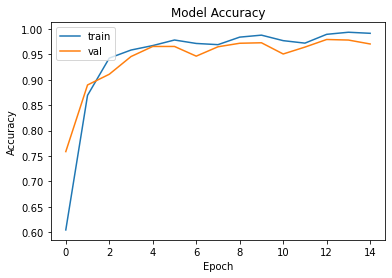

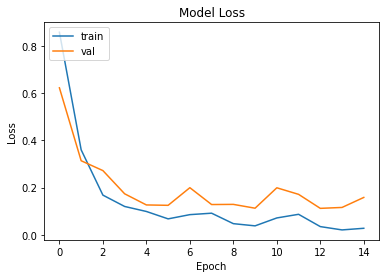

In [48]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
history = model.fit(
                    X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    validation_split=0.1,
                    epochs=15, 
                    batch_size=64)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
score = model.evaluate(np.asarray(X_test),np.asarray (y_test) ) 

199/199 [==============================] - 2s 8ms/step - loss: 0.0717 - accuracy: 0.9819


In [40]:
model.save("/content/drive/MyDrive/PFE_RESULTS_DATA/augmentation0/scaling/CNN1D/CNN1D.h5")

In [41]:
import json

with open('/content/drive/MyDrive/PFE_RESULTS_DATA/augmentation0/scaling/CNN1D/CNN1D_score.json', 'w+') as file:

    json.dump(score, file)

In [42]:
model= tf.keras.models.load_model("/content/drive/MyDrive/PFE_RESULTS_DATA/augmentation0/scaling/CNN1D/CNN1D.h5")

In [43]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True
    )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
y_pred = model.predict(np.asarray(X_test))

199/199 [==============================] - 1s 4ms/step


In [45]:
y_predicted_labels = [{0:"Normal",1:"Neuropathie",2:"Myopathie"}[i] for i in np.argmax(y_pred,axis=1)]

In [46]:
y_true_labels = [{0:"Normal",1:"Neuropathie",2:"Myopathie"}[i] for i in y_test]

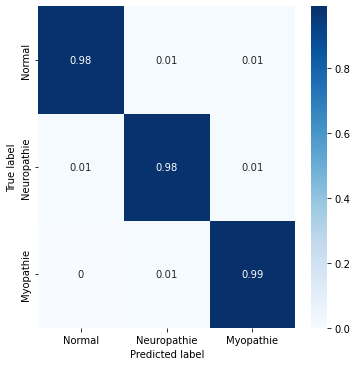

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=np.argmax(y_pred,axis=1)).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = ["Normal","Neuropathie",'Myopathie'], 
                     columns = ["Normal","Neuropathie",'Myopathie'])

figure = plt.figure(figsize=(5,5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()




In [6]:
a =[[1,1,1,1],[2,2,3,4]]
b = [a[1][0]]
p=len(a)
print(p)
l=len(a[1])
print(l)
print(b)
print(a[::-1])
#print(a[::-1].index([1,1,1]))
f=[[1,1,1],[2,2,3,4]]
random_noise_6 = np.random.normal(0,1,len(a[0]))

a = list(map(lambda x : x + random_noise_6, a))
print(a)
random_noise_6

c=[[1,1,1,1],[2,2,3,4]]
c = np.array(c)
noise = np.random.normal(0, 1, size=c.shape)
c=np.add(c,noise)
print(c.shape)
noise.shape

2
4
[2]
[[2, 2, 3, 4], [1, 1, 1, 1]]
[array([ 2.70522842,  0.64832793,  2.06528057, -0.49849931]), array([3.70522842, 1.64832793, 4.06528057, 2.50150069])]
(2, 4)


(2, 4)